# custom model two - without augmenation 10 classes

## Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [2]:
import datetime
import operator
##open cv
import cv2
from google.colab.patches import cv2_imshow
import random
#numpy-pandas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#tensorflow and utilities
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers

#tensorflow model, layers, optimizers etc
from tensorflow.keras import Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, AveragePooling2D, GlobalAveragePooling2D

#callbacks
from tensorflow.keras.callbacks import BaseLogger, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ReduceLROnPlateau

#pretrained models
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

## 2. Import Data

In [3]:
#getting dataframes of train and test data
train_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dermnet/Files/final_dataframe/final_test_df.csv")


train_df["path"] = train_df["class"] + "/" + train_df["image_name"]
test_df["path"] = test_df["class"] + "/" + test_df["image_name"]

print("Shape of train dataset is {}.".format(train_df.shape))
print("Shape of test dataset is {}.".format(test_df.shape))

train_df["class"].value_counts()

Shape of train dataset is (14523, 4).
Shape of test dataset is (3527, 4).


Seborrheic Keratoses and other Benign Tumors                          1350
Psoriasis pictures Lichen Planus and related diseases                 1297
Eczema Photos                                                         1222
Tinea Ringworm Candidiasis and other Fungal Infections                1218
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    1118
Warts Molluscum and other Viral Infections                             985
Nail Fungus and other Nail Disease                                     855
Systemic Disease                                                       568
Acne and Rosacea Photos                                                561
Light Diseases and Disorders of Pigmentation                           546
Atopic Dermatitis Photos                                               485
Vascular Tumors                                                        482
Melanoma Skin Cancer Nevi and Moles                                    456
Bullous Disease Photos   

## 3. Class

In [4]:
class_to_keep = ["Bullous Disease Photos" , "Lupus and other Connective Tissue diseases", "Vasculitis Photos", "Exanthems and Drug Eruptions",
                 "Scabies Lyme Disease and other Infestations and Bites",  "Herpes HPV and other STDs Photos", "Cellulitis Impetigo and other Bacterial Infections",
                 "Poison Ivy Photos and other Contact Dermatitis", "Hair Loss Photos Alopecia and other Hair Diseases", "Urticaria Hives"]

train_df_m1 = train_df[train_df["class"].isin(class_to_keep)]
test_df_m1 = test_df[test_df["class"].isin(class_to_keep)]

#getting the values counts
train_df_m1["class"].value_counts()

Bullous Disease Photos                                   440
Lupus and other Connective Tissue diseases               415
Vasculitis Photos                                        405
Exanthems and Drug Eruptions                             397
Scabies Lyme Disease and other Infestations and Bites    383
Herpes HPV and other STDs Photos                         382
Cellulitis Impetigo and other Bacterial Infections       284
Poison Ivy Photos and other Contact Dermatitis           250
Hair Loss Photos Alopecia and other Hair Diseases        212
Urticaria Hives                                          212
Name: class, dtype: int64

### 1.1 Train Test Split and Categorical Encoding of output label

In [5]:
train_df_final, validation_df_final = train_test_split(train_df_m1, test_size=0.20)
print("Shape of train : {}.".format(train_df_final.shape))
print("Shape of test : {}.".format(validation_df_final.shape))

test_df_m1["class_cat"] = test_df_m1["class"].astype('category').cat.codes
y_true = test_df_m1["class_cat"].values

Shape of train : (2704, 4).
Shape of test : (676, 4).


## 4. Data Pipeline

In [6]:
channels = 3
batchsize = 32
num_classes = 10
img_rows = 256; img_cols = 256 

In [7]:
#datagwn without augmentation
datagen_aug = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.3,
                                 width_shift_range=0.4,
                                 horizontal_flip=True,
                                 brightness_range=(0.2,0.5),
                                 fill_mode='nearest')

#Train Generator
train_gen_aug = datagen_aug.flow_from_dataframe(dataframe = train_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

#Validation Generator
valid_gen_aug = datagen_aug.flow_from_dataframe(dataframe = validation_df_final, 
                                        directory="/content/drive/MyDrive/Dermnet/Images/train/", x_col="path", y_col="class", 
                                        class_mode="categorical", subset="training", shuffle=True,
                                        target_size=(img_rows, img_cols), 
                                        batch_size = batchsize, 
                                        color_mode='rgb',
                                        seed=42)

Found 2704 validated image filenames belonging to 10 classes.
Found 676 validated image filenames belonging to 10 classes.


## 5. Callbacks

In [8]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) 


#reduce learning rate
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=2,
                             min_lr=0.001)

## 6. Loss Function

In [9]:
def loss_plot(train_loss, test_loss, total_epoch):
    """
    This function plots the loss graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_loss);  plt.plot(test_loss)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Loss", "Validation_Loss"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Log Loss", fontsize=10)
    plt.title("Loss Plot for train and validation dataset", fontsize=20)
    return plt.show()



def accuracy_plot(train_accuracy, test_accuracy, total_epoch):
    """
    This function plots the accuracy graph of both train and validation dataset.
    """
    fig = plt.figure(figsize=(15,5))  #setting up figure size
    plt.plot(train_accuracy);  plt.plot(test_accuracy)
    #setting up ticks
    plt.xticks(range(1,total_epoch))
    plt.legend(["Train_Accuracy", "Validation_Accuracy"])
    #setting up labels
    plt.xlabel("Number of Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Plot for train and validation dataset", fontsize=20)
    return plt.show()


## 7. custom model 2 with augmentation

In [10]:
def custom_model_2(img_rows, img_cols, channel, nb_train_samples, num_classes):
    """
    This is sequential function for convolutional based image classification model.
    input:
    ------
        img_rows           : width of the image
        img_cols           : height of the image
        channels           : rgb(3), grayscale(1)
        nb_train_samples   : number of training samples
        num_classes        : number of classes to be trained
    output:
    -------
        model setup
    """

    #creating a sequential model
    model= Sequential()
    #conv layers
    model.add(Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(img_rows, img_cols, channel)))
    model.add(Conv2D(filters=32, kernel_size = (3,3), activation='tanh', ))  #kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(filters=32,kernel_size = (3,3),activation='tanh',  ))  #kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(filters=32,kernel_size = (3,3),activation='tanh', ))  #kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)
    model.add(MaxPool2D(2,2))
    #flattening the layer
    model.add(Flatten())
    model.add(Dense(nb_train_samples,activation='relu'))
    model.add(Dense(num_classes, activation = 'softmax'))

    return model

## 8. Training and compilation

In [11]:
epochs= 30
nb_train_samples = 2704
nb_validation_samples = 676

In [ ]:
# model function call
model = custom_model_2(img_rows,img_cols,channels,nb_train_samples, num_classes)

#compilation of model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(0.001))

# fitting model
history = model.fit(train_gen_aug, steps_per_epoch = nb_train_samples//batchsize, epochs=epochs, 
                    validation_data=valid_gen_aug,
                    validation_steps=nb_validation_samples//batchsize,
                    callbacks = [earlyStopping, reduceLR])

Epoch 1/30
84/84 [==============================] - 1293s 15s/step - loss: 3.6087 - accuracy: 0.1538 - val_loss: 2.1760 - val_accuracy: 0.2068
Epoch 2/30
84/84 [==============================] - 76s 903ms/step - loss: 2.1549 - accuracy: 0.2063 - val_loss: 2.1428 - val_accuracy: 0.2307
Epoch 3/30
84/84 [==============================] - 76s 910ms/step - loss: 2.1312 - accuracy: 0.2283 - val_loss: 2.1117 - val_accuracy: 0.2321
Epoch 4/30
84/84 [==============================] - 77s 923ms/step - loss: 2.0997 - accuracy: 0.2310 - val_loss: 2.1384 - val_accuracy: 0.2098
Epoch 5/30
84/84 [==============================] - 75s 898ms/step - loss: 2.0866 - accuracy: 0.2282 - val_loss: 2.1461 - val_accuracy: 0.2068
Epoch 6/30
84/84 [==============================] - 78s 924ms/step - loss: 2.1042 - accuracy: 0.2275 - val_loss: 2.1369 - val_accuracy: 0.2321
Epoch 7/30
84/84 [==============================] - 74s 887ms/step - loss: 2.0753 - accuracy: 0.2367 - val_loss: 2.1190 - val_accuracy: 0.2396

## 9 .Save Model

In [ ]:
model.save('/content/drive/MyDrive/Dermnet/SavedModels/expeiment6.h5')  # creates a HDF5 file 

In [ ]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)       

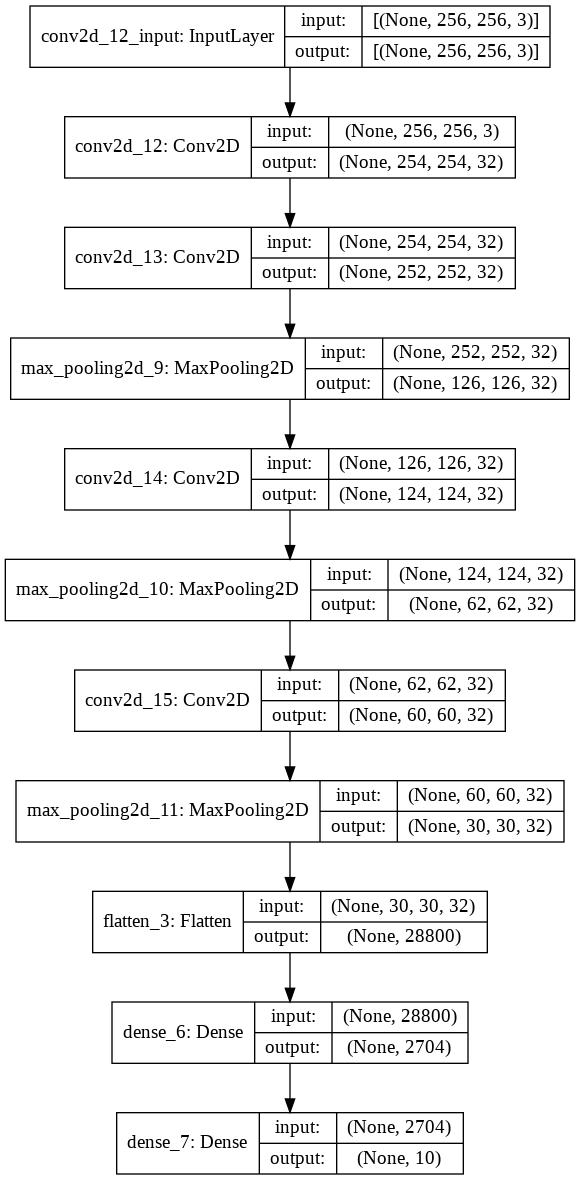

In [ ]:
tf.keras.utils.plot_model(model, to_file="experiment6.jpg", show_shapes=True)

## 10. Loss and Accuracy Plot

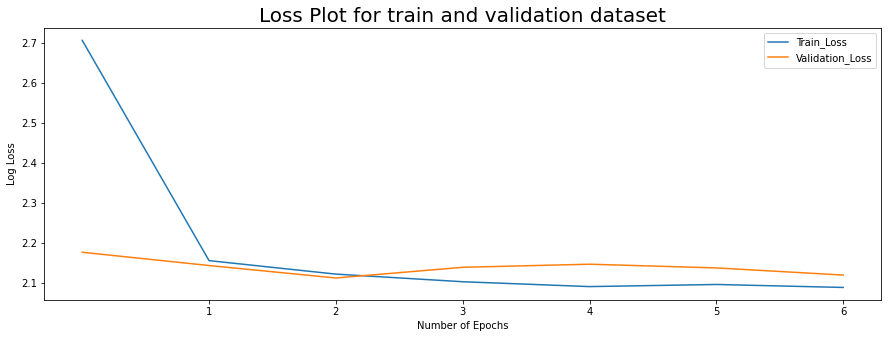

In [ ]:
loss_plot(history.history["loss"], history.history["val_loss"], 7)

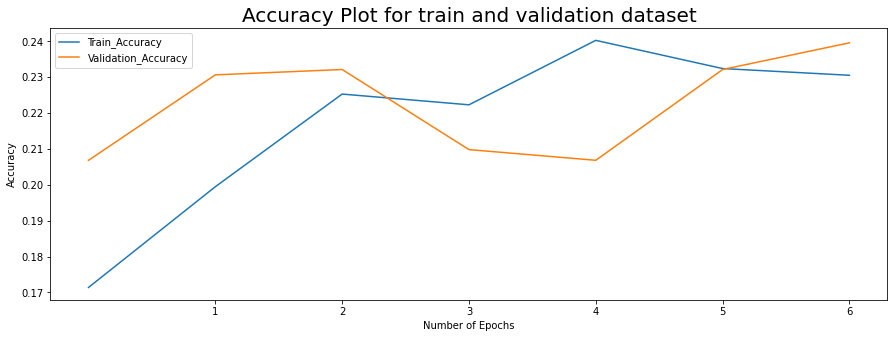

In [ ]:
accuracy_plot(history.history["accuracy"], history.history["val_accuracy"], 7)

## 11. Prediction 

In [12]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Dermnet/SavedModels/expeiment6.h5')

In [13]:
#Validation Generator
test_generator = datagen_aug.flow_from_dataframe(dataframe = test_df_m1, 
                                            directory="/content/drive/MyDrive/Dermnet/Images/test/", 
                                            x_col="path", 
                                            y_col=None, 
                                            class_mode=None,
                                            subset=None,
                                            shuffle=False,
                                            target_size=(img_rows, img_cols),
                                            batch_size = batchsize,
                                            color_mode='rgb')

#predicting all values
output_scores = model.predict_generator(test_generator)

Found 823 validated image filenames.


## 12. Evaluation Metric

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
#getting output scores
class_outputs = [max(enumerate(val), key=operator.itemgetter(1)) for val in output_scores]
#getting prediction values
y_pred = [val[0] for val in class_outputs]


#getting confusion metrix
conf_matrix = confusion_matrix(y_true, y_pred)


#getting classification report 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.51      0.26       113
           1       0.00      0.00      0.00        70
           2       0.29      0.24      0.26       100
           3       0.36      0.67      0.47        46
           4       0.30      0.47      0.37        86
           5       0.24      0.21      0.23       100
           6       0.14      0.02      0.03        59
           7       0.24      0.05      0.09        92
           8       0.00      0.00      0.00        53
           9       0.14      0.10      0.11       104

    accuracy                           0.23       823
   macro avg       0.19      0.23      0.18       823
weighted avg       0.19      0.23      0.19       823



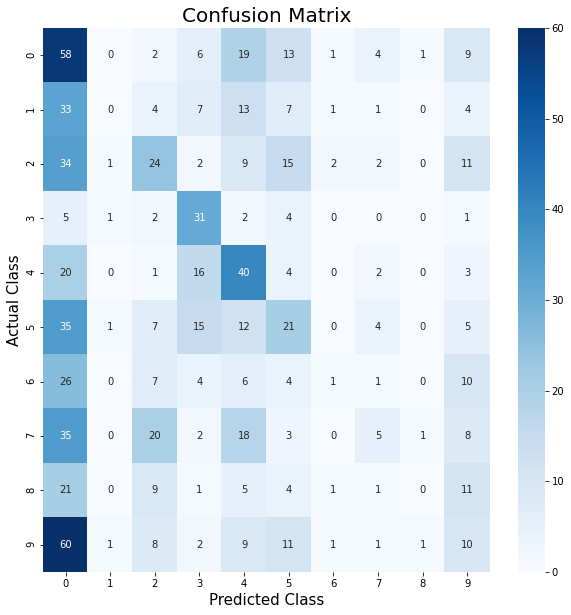

In [16]:
fig = plt.figure(figsize=(10,10))
plot = sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d")
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Actual Class", fontsize=15)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

In [17]:
## accuracy scores
print("Accuracy Score        {:.4f}.".format(accuracy_score(y_true,y_pred)))
print("Overall f1 score      {:.4f}.".format(f1_score(y_true, y_pred, average='micro')))
print("Overall Precision     {:.4f}.".format(precision_score(y_true, y_pred, average='micro')))
print("Overall Recall        {:.4f}.".format(recall_score(y_true, y_pred, average='micro')))

Accuracy Score        0.2309.
Overall f1 score      0.2309.
Overall Precision     0.2309.
Overall Recall        0.2309.
